# Lab 5: Non-negative Matrix Factorization

### Work done by Mohamed Amine HACHICHA

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *aml.centralesupelec.2020@gmail.com* a week from now and put **"NMF Lab"** in the subject. 

All questions will be graded unless it is explicitely indicated.

We begin with the standard imports:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [5]:
class MYNMF():
    
    def __init__(self, n_components, random_state=42, max_iter=200):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.components_ = None    # shape (r, p)
        self.random_state = random_state
        self.err_ = []
    def fit_transform(self, data, mu=1., lambd=1., nu=1.):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        data: (n, p) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (n, r) np.array
                    Embedding matrix        
        """        
        # Get the data shape
        n, p = data.shape[0], data.shape[1]
        
        # Initialize the D and S matrices
        np.random.seed(self.random_state)
        D = np.random.rand(n, self.n_components_)
        S = np.random.rand(self.n_components_, p)
        
        # Save the nu parameter for later predictions
        self.nu_ = nu
    
        def err(X, D, S):
            # This function calculates the loss function value
            return 0.5 * (np.linalg.norm(X - np.dot(D, S), ord=2) + mu * np.linalg.norm(S, 2) + 2 * lambd * np.linalg.norm(S, 1) + nu * np.linalg.norm(D, 2))
        self.err_.append(err(data, D, S))
        
        for i in range(self.max_iter_):
            
            # Update D
            D = np.multiply(D, 
                            np.divide(np.dot(data, np.transpose(S)), 
                                      np.dot(D, 
                                             (np.dot(S, np.transpose(S)) + nu * np.identity(self.n_components_)))))
            
            
            # Update S
            S = np.multiply(S,
                           np.divide(np.dot(np.transpose(D), data) - lambd * np.ones((self.n_components_, p)),
                                    np.dot(np.dot(np.transpose(D), D) + mu * np.identity(self.n_components_), S)))
            
            self.err_.append(err(data, D, S))

        self.components_ = S
        embedding = D
        return embedding  
    
    
    def inverse_transform(self, embedding):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (n, r) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (n, p) np.array  
                   reconstructed data matrix
        """       
        data_hat = np.dot(embedding, self.components_)
        return data_hat

    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        """
        # Initialize the D matrix
        D = np.random.rand(X.shape[0], self.n_components_)
        
        # The S matrix is the components matrix and it's fixed
        S = self.components_
        for i in range(self.max_iter_):
            # Only update D
            D = np.multiply(D, 
                            np.divide(np.dot(X, np.transpose(S)), 
                                      np.dot(D, 
                                             (np.dot(S, np.transpose(S)) + self.nu_ * np.identity(self.n_components_)))))
            
        # The observation i belongs to the cluster with the highest coefficient in the corresponding row in the embedding matrix
        labels = np.argmax(D, axis=1)
            
        return labels
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        # Initialize the D matrix
        D = np.random.rand(X.shape[0], self.n_components_)
        
        # The S matrix is the components matrix and it's fixed
        S = self.components_
        
        for i in range(self.max_iter_):
            # Only update D
            D = np.multiply(D, 
                            np.divide(np.dot(X, np.transpose(S)), 
                                      np.dot(D, 
                                             (np.dot(S, np.transpose(S)) + self.nu_ * np.identity(self.n_components_)))))
        # We normalize each row with the sum of its' elements to get probabilities
        proba = np.array([x_i/np.sum(x_i) for x_i in D])
        
        return proba

In [7]:
# Test that the NMF class works on random matrices
model = MYNMF(n_components=5, random_state=42, max_iter=200)
X1 = 20 * np.random.rand(10000, 20)
D = model.fit_transform(X1, mu=0.01, lambd=0.01, nu=0.01)
X2 = 5 * np.random.rand(1000, 20)
probas = model.predict_proba(X2)
print(probas.shape)

(1000, 5)


## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

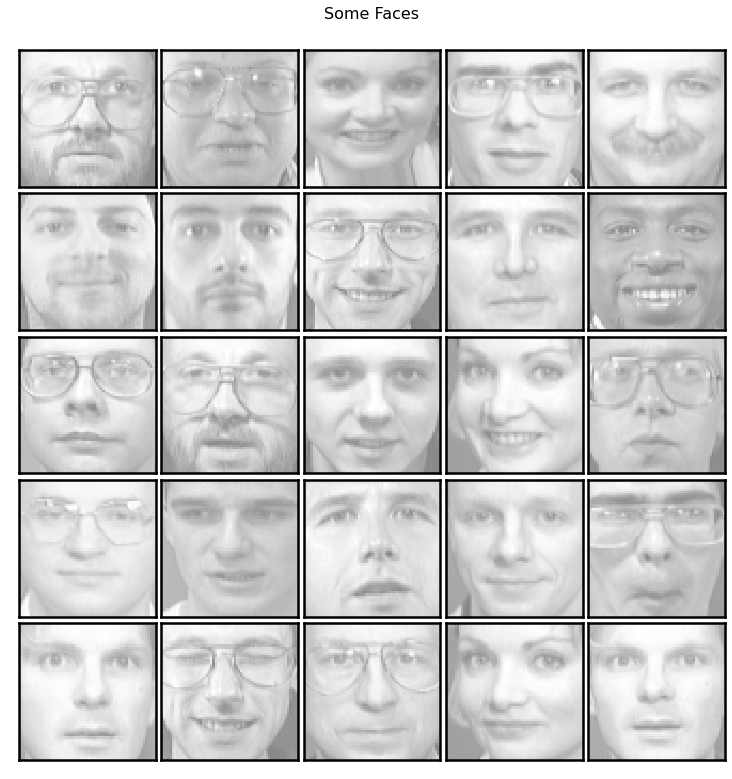

In [8]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


Apply *your* NMF algorithm for this dataset and plot the approximated face pictures.

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Explain how to interpret both matrices W and H.
- Discuss the results you have obtained
- Conduct a critical analysis of your choice. Concretely, choose an aspect or two of the NMF method (e.g. Loss, Clustering, Geometry of the Embedding Space, Choice of the number of components r, any other of your choice), write code for it, test it, present (a) figure(s), and discuss. 

In [9]:
# Fit the NMF model on faces data and compute the approximated images
model = MYNMF(n_components=49, random_state=42, max_iter=200)
faces_embedding = model.fit_transform(faces)
faces_hat = model.inverse_transform(faces_embedding)

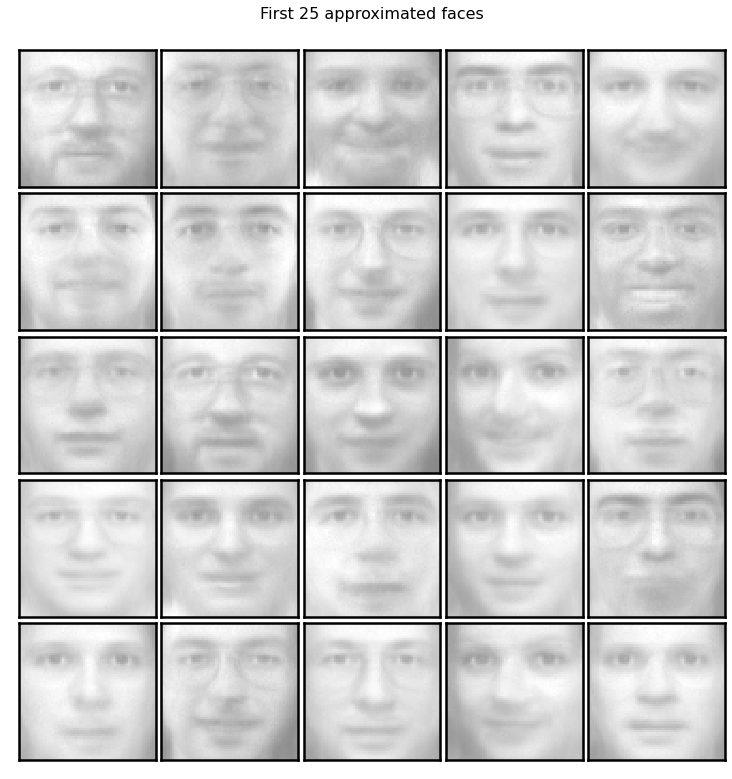

In [10]:
# Show the first 25 approximated faces
plot_gallery(title="First 25 approximated faces", 
             images=faces_hat[:25], 
             image_shape=image_shape)

### Plotting the W Matrix

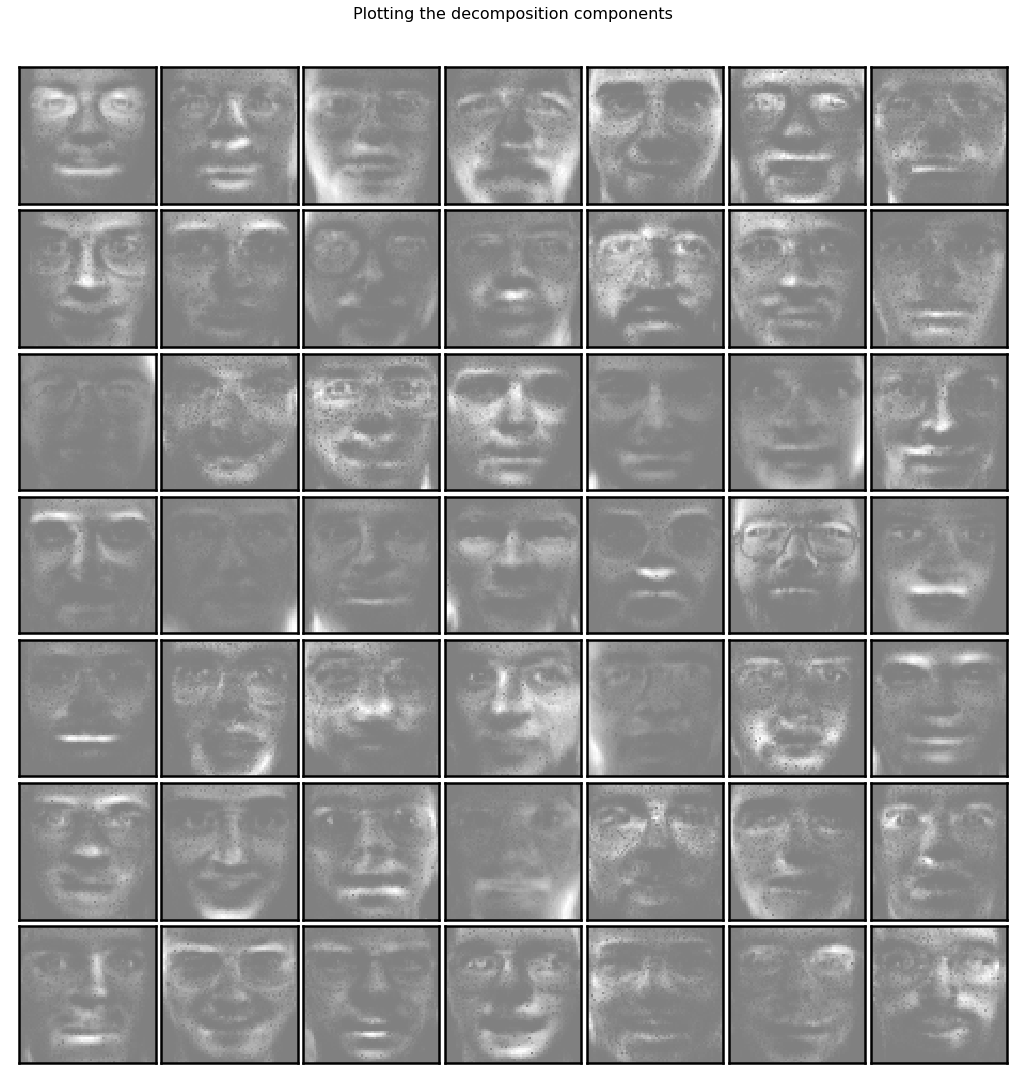

In [11]:
# Plot the W matrix in a 7x7 grid
plot_gallery(title="Plotting the decomposition components", 
             images=model.components_, 
             image_shape=image_shape)

#### W and H matrices interpretation
The W matrix corresponds to the components in the approximation space. More concretely, it corresponds to parts and shapes in specific regions of the image (i.e face). For example, we can see in the grid above that the first component focuses on the eyes and the lower lip. The second component focuses on the contour of the nose and the mouth.

The H matrix is the embedding matrix. It attributes coefficients to each face for each component.

### Results discussion :

In [12]:
def plot_before_after(image_before, image_after, image_shape, index, cmap=plt.cm.gray):
    # Plots a face an its' approximation
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Face No.{} before and after approximation".format(index), size=20)
    
    vmax_before = max(image_before.max(), -image_before.min())
    axes[0].imshow(image_before.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax_before, vmax=vmax_before)
    axes[0].set(xticks=(),
                yticks=())
    
    vmax_after = max(image_after.max(), -image_after.min())
    axes[1].imshow(image_after.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax_after, vmax=vmax_after)
    axes[1].set(xticks=(),
                yticks=())

    fig.subplots_adjust(top=0.99, bottom=0)  # insert space below the suptitle

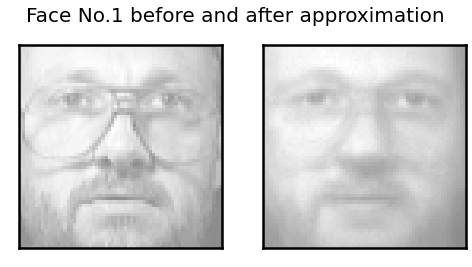

In [13]:
plot_before_after(image_before=faces[0], image_after=faces_hat[0], image_shape=(64, 64), index=1)

##### We notice an acceptable similarity between the original and the approximated images. In general, we are able to recognize the persons after approximation. Nevertheless, details like mustaches and eye glasses are less preserved.

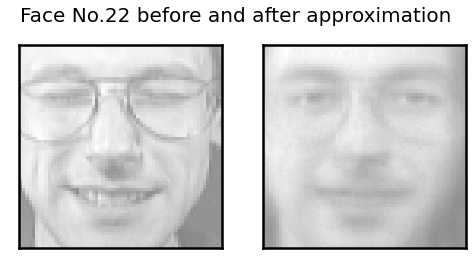

In [14]:
plot_before_after(image_before=faces[21], image_after=faces_hat[21], image_shape=(64, 64), index=22)

#### Some facial expressions (laughing, closed eyes,..) are sometimes omitted in the approximated faces. See for example for this person, originally he had his eyes closed, but after approximation he has open eyes and his eye glasses are less visible.

#### Let's run the model while increasing the number of components

### How to select r

To select r, we choose an elbow method. We fit an NMF for many number of possible components and we plot the evolution of : 
  $\mathcal{L_t}(D, S) = \frac{1}{2}\|X-H W\|_{F}^{2}$

In [15]:
n_components_list = [5*i for i in range(1, 21)]
losses = []
for n_comp in n_components_list:
    model_i = MYNMF(n_components=n_comp, random_state=42, max_iter=100)
    faces_embedding_i = model_i.fit_transform(faces)
    faces_hat_i = model_i.inverse_transform(faces_embedding_i)
    losses.append(np.linalg.norm((faces - faces_hat_i), ord=2))


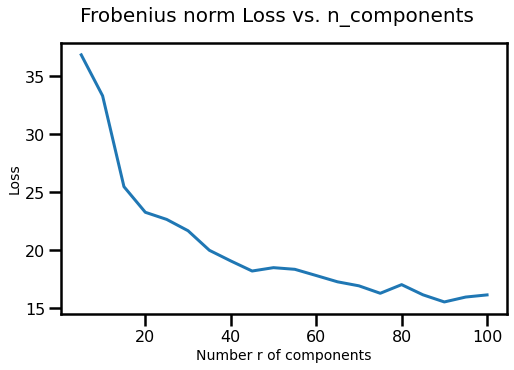

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.plot(n_components_list, losses)
fig.suptitle('Frobenius norm Loss vs. n_components', size=20)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel('Number r of components', size=14)
ax.set_ylabel('Loss', size=14)

plt.show()

#### Using the elbow method, r=40 seems a good value for the number of components. For our experience, we took r=49 so our first guess was appropriate.

##### Let's examine the faces of the first cluster when we take only **10 clusters**

The cluster has 33 elements.


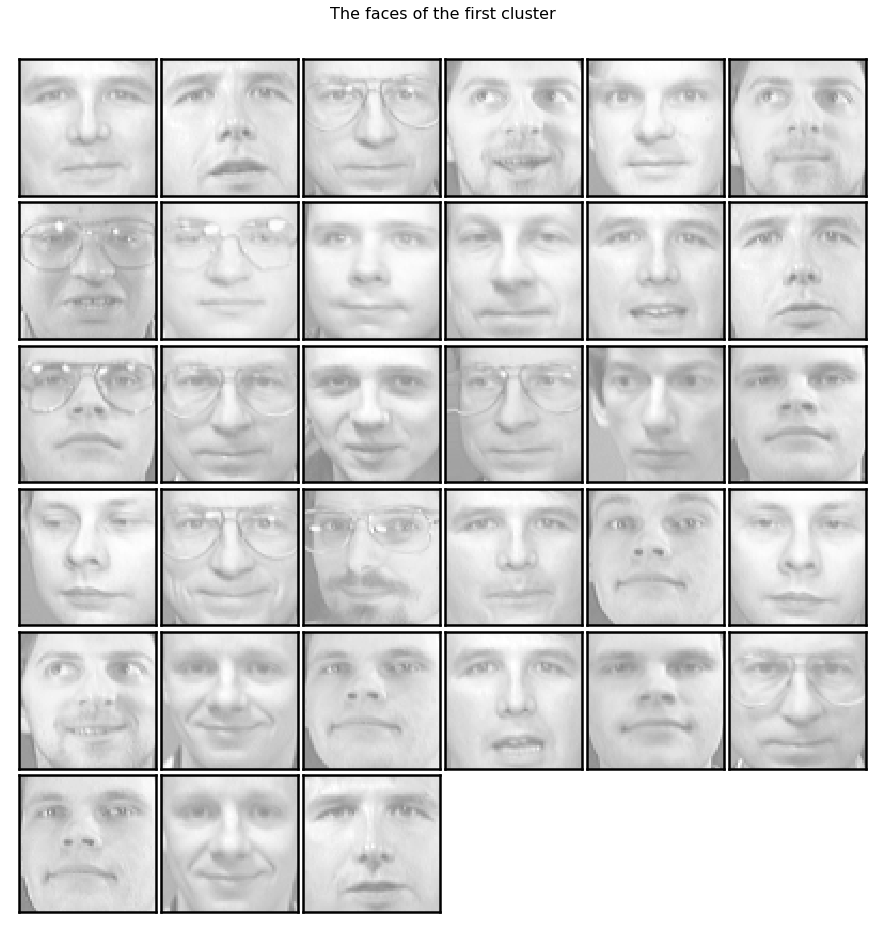

In [24]:
model_10 = MYNMF(n_components=10, random_state=42, max_iter=200)
faces_embedding_10 = model_10.fit_transform(faces)

# Picking the faces of cluster 0 and plotting them
cluster_0 = faces[model_10.predict_label(faces) == 0]
print("The cluster has {} elements.".format(len(cluster_0)))
plot_gallery(title="The faces of the first cluster", 
             images=cluster_0, 
             image_shape=image_shape)

#### The main remarks are :
 - They are all men (I guess?)
 - There are two or more pictures for at least four persons in this cluster. Do these persons have images in other clusters though?
 - The majority have overall neutral face expressions, no facial hair and all have their eyes open
 - They have similar skin colours.


### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model, print top words

model = NMF(n_components=n_components, alpha=0.05, random_state=42)
model.fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(model.components_.T, tfidf_feature_names, n_top_words)

Topic #0: just people don think like know say make did really time way ve right sure good going want got wrong
Topic #1: windows use using window dos program application os drivers software help screen running ms code work motif mode ve pc
Topic #2: god jesus bible faith does christian christians christ believe life heaven sin lord church true religion mary human belief love
Topic #3: thanks know does mail advance hi info interested anybody email like looking help appreciated card information list send need post
Topic #4: car new 00 bike 10 price space power cars good year sale engine years used cost miles condition great 000
Topic #5: edu soon com send university internet mail ftp mit information article cc pub address hope email mac program blood contact
Topic #6: file problem files format ftp space win sound read pub program available site help version image book copy save memory
Topic #7: game team year games win play season players nhl runs toronto ll flyers division goal won hock

#### The NMF succeeds to identify coherent topics.

For example it's clear that topic #1 is related to computers software and hardware. 
  
Topic #2 is related to religion.
  
Topic #3: email communications
  
Topic #4 is all about means of transportation
etc..

Topic #0 isn't very clear. Maybe it's about adjectives, judgements and making opinions..

In [20]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


With which topics does the nmf model best associate this new sample? Does it make sense? What about another new sample?

How does this NMF method compare to other embedding methods you know in NLP?

In [21]:
new_sample_tfidf = tfidf_vectorizer.transform([new_data_sample])
print("This sample belongs to topic {}".format(model.transform(new_sample_tfidf).argmax()))

This sample belongs to topic 2


#### This sample has a religious subject so it makes sense that the NMF puts it in topic 2.

In [22]:
new_data_sample = dataset.data[2020]  # unseen
print(new_data_sample)
new_sample_tfidf = tfidf_vectorizer.transform([new_data_sample])
print('####')
print("This sample belongs to topic {}".format(model.transform(new_sample_tfidf).argmax()))


I was wondering if any one knew how the various hard drive compression utilities work.  My hard
drive is getting full and I don't want to have to buy a new one.  What I'm intrested in is speed
,ease of use, amount of compression, and any other aspect you think might be important as I've never
use one of these things before. thanks  Morgan Bullard mb4008@coewl.cen.uiuc.edu
						or     mjbb@uxa.cso.uiuc.edu

####
This sample belongs to topic 8


#### This new sample also clearly makes sense !

### We now try embedding with LDA

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n_components, max_iter=50, learning_method='batch', random_state=42)
lda.fit(tfidf)

print_top_words(lda.components_.T, tfidf_feature_names, n_top_words)

Topic #0: cubs does know got thanks cases interested jewish mode pro piece driving figure aids especially comments source advance built runs
Topic #1: mike division gm edu al ibm toronto ve question win magi com thinking related games soon season list consider think
Topic #2: library dog freedom language door reading number text objects software bob wanted public net available comp extra 250 20 subject
Topic #3: people don god think just like know good time say does did really way believe game said make true doesn
Topic #4: cd vs rom armenians armenian armenia mil ll 00 pp copies ground azerbaijan women performance 55 couldn 44 air support
Topic #5: nhl flyers game players san teams toronto 32 team leafs play amiga record 72 18 19 season year 31 period
Topic #6: edu com 3d archive written mit specifically article say history book james sound source return parts interested books au effective
Topic #7: disease models medical test experience case manager health study edu motif window want

#### LDA gives some coherent topics, like topic #8 which focuses on high-tech related words or topic #5 focusing on sports in general.
#### However, NMF results are clearly better: topics keywords are way more homogenous and coherent.